<a href="https://colab.research.google.com/github/lucaskrieger24/PML_exam/blob/main/BERT_esm1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install and load models

In [1]:
%%time
# for other models see: https://github.com/facebookresearch/esm#main-models-you-should-use-

# mount google-drive, download to google-drive,
# will run faster next time!
'''
import os
import torch
hub_dir = "/content/drive/MyDrive/AlgoSB"
if not os.path.isdir(hub_dir): os.mkdir(hub_dir)
torch.hub.set_dir(hub_dir)
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")
'''

# this step will take ~3mins
import torch
import os
os.system("apt-get install aria2 -qq")
os.system("mkdir -p /root/.cache/torch/hub/checkpoints/")
# os.system("aria2c -q -x 16 -d /root/.cache/torch/hub/ https://github.com/facebookresearch/esm/archive/main.zip")
# os.system("aria2c -q -x 16 -d /root/.cache/torch/hub/checkpoints/ https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt")
# os.system("aria2c -q -x 16 -d /root/.cache/torch/hub/checkpoints/ https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt")
# # model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")

CPU times: user 1.25 s, sys: 252 ms, total: 1.51 s
Wall time: 4.98 s


0

In [2]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

Using cache found in /root/.cache/torch/hub/facebookresearch_esm_main


In [3]:
# put model on GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval()
#model.args.token_dropout = False

# alphabet size
esm_alphabet_len = len(alphabet.all_toks)
esm_alphabet = "".join(alphabet.all_toks[4:24])+"-"

In [4]:
!wget -qnc https://raw.githubusercontent.com/sokrypton/algosb_2021/main/utils.py
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from utils import *

# analyze MSA

In [ ]:
# RL29_ECOLI (essential ribosomal protein from ECOLI)
!wget -qnc https://files.ipd.uw.edu/krypton/RL29.uni.1e-10.i8.i90c75.a3m
headers, seqs = parse_fasta("RL29.uni.1e-10.i8.i90c75.a3m", a3m = True)
msa = mk_msa(seqs, alphabet=esm_alphabet)
seq = seqs[0]
print(msa.shape)
print(seq)

(11367, 63, 21)
MKAKELREKSVEELNTELLNLLREQFNLRMQAASGQLQQSHLLKQVRRDVARVKTLLNEKAGA


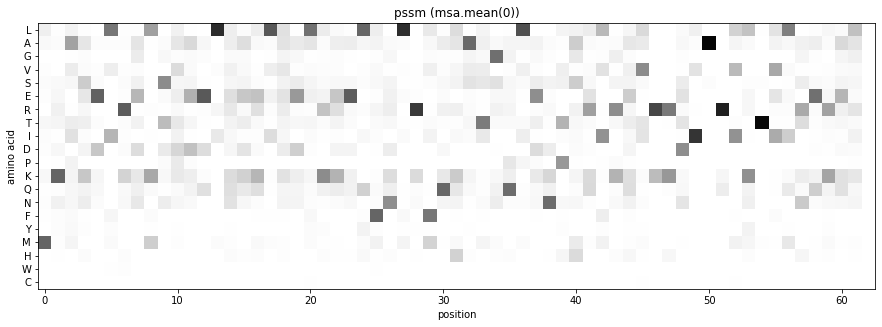

In [ ]:
plt.figure(figsize=(15,5))
plt.title("pssm (msa.mean(0))")
plt.imshow(msa.mean(0)[...,:20].T, vmin=0, vmax=1, cmap="binary")
plt.yticks(range(20),esm_alphabet[:20])
plt.xlabel("position"); plt.ylabel("amino acid")
plt.show()

#analyze BERT-ESM1b

In [5]:
protein_seq = "MANINLKEITLIVGVVTACYWNSLFCGFVFDDVSAILDNKDLHPSTPLKTLFQNDFWGTPMSEERSHKSYRPLTVLTFRLNYLLSELKPMSYHLLNMIFHAVVSVIFLKVCKLFLDNKSSVIASLLFAVHPIHTEAVTGVVGRAELLSSIFFLAAFLSYTRSKGPDNSIIWTPIALTVFLVAVATLCKEQGITVVGICCVYEVFIAQGYTLPLLCTTAGQFLRGKGSIPFSMLQTLVKLIVLMFSTLLLVVIRVQVIQSQLPVFTRFDNPAAVSPTPTRQLTFNYLLPVNAWLLLNPSELCCDWTMGTIPLIESLLDIRNLATFTFFCFLGMLGVFSIRYSGDSSKTVLMALCLMALPFIPASNLFFPVGFVVAERVLYVPSMGFCILVAHGWQKISTKSVFKKLSWICLSMVILTHSLKTFHRNWDWESEYTLFMSALKVNKNNAKLWNNVGHALENEKNFERALKYFLQATHVQPDDIGAHMNVGRTYKNLNRTKEAEESYMMAKSLMPQIIPGKKYAARIAPNHLNVYINLANLIRANESRLEEADQLYRQAISMRPDFKQAYISRGELLLKMNKPLKAKEAYLKALELDRNNADLWYNLAIVHIELKEPNEALKKNFNRALELNPKHKLALFNSAIVMQESGEVKLRPEARKRLLSYINEEPLDANGYFNLGMLAMDDKKDNEAEIWMKKAIKLQADFRSALFNLALLYSQTAKELKALPILEELLRYYPDHIKGLILKGDILMNQKKDILGAKKCFERILEMDPSNVQGKHNLCVVYFEEKDLLKAERCLLETLALAPHEEYIQRHLNIVRDKISSSSFIEPIFPTSKISSVEGKKIPTESVKEIRGESRQTQIVKTSDNKSQSKSNKQLGKNGDEETPHKTTKDIKEIEKKRVAALKRLEEIERILNGE"
linker = "GSGS"
binder = "MEIDEPLTRRAMPSS"
seq = linker + protein_seq + binder

In [6]:
def get_logits(seq):
  x,ln = alphabet.get_batch_converter()([("seq",seq)])[-1],len(seq)
  with torch.no_grad():
    f = lambda x: model(x)["logits"][0,1:(ln+1),4:24].cpu().numpy()
    x = x.to(device)
    logits = f(x)
    return logits

def get_masked_logits(seq, p=None, get_pll=False):
  x,ln = alphabet.get_batch_converter()([(None,seq)])[-1],len(seq)
  if p is None: p = ln
  with torch.no_grad():
    def f(x):
      fx = model(x)["logits"][:,1:(ln+1),4:24]
      return fx

    logits = np.zeros((ln,20))
    for n in range(0,ln,p):
      m = min(n+p,ln)
      x_h = torch.tile(torch.clone(x),[m-n,1])
      for i in range(m-n):
        x_h[i,n+i+1] = alphabet.mask_idx
      fx_h = f(x_h.to(device))
      for i in range(m-n):
        logits[n+i] = fx_h[i,n+i].cpu().numpy()
  if get_pll:
    logits = np.log(softmax(logits,-1))
    x = x.cpu().numpy()[0]
    x = x[1:(ln+1)] - 4
    return sum([logits[n,i] for n,i in enumerate(x)])
  else:
    return logits

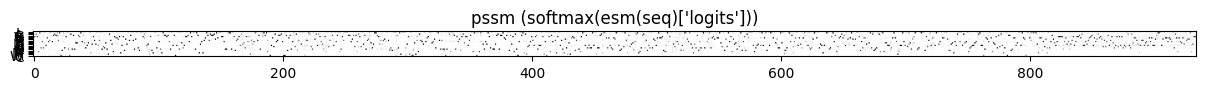

In [8]:
# get PSSM version 1
plt.figure(figsize=(15,5))
plt.title("pssm (softmax(esm(seq)['logits']))")
plt.imshow(softmax(get_logits(seq),-1).T, vmin=0, vmax=1, cmap="binary")
plt.yticks(range(20),esm_alphabet[:20])
plt.show()

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(softmax(get_logits(seq),-1),
            msa.mean(0)[...,:20],s=10)
plt.xlabel("esm-pssm (unmasked)")
plt.ylabel("natural-pssm")
plt.plot([0,1],[0,1],color="black")
plt.show()

NameError: name 'msa' is not defined

<Figure size 500x500 with 0 Axes>

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.17 GiB. GPU 0 has a total capacity of 14.74 GiB of which 3.68 GiB is free. Process 6282 has 11.06 GiB memory in use. Of the allocated memory 10.86 GiB is allocated by PyTorch, and 78.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

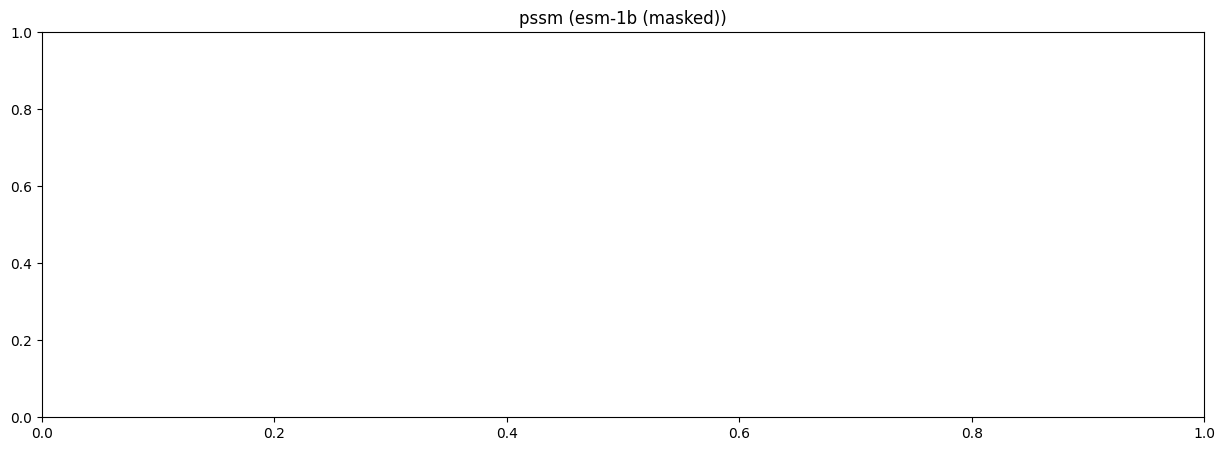

In [10]:
# get PSSM version 2
# mask one position at a time
plt.figure(figsize=(15,5))
plt.title("pssm (esm-2 (masked))")
plt.imshow(softmax(get_masked_logits(seq),-1).T, cmap="binary", vmin=0, vmax=1)
plt.yticks(range(20),esm_alphabet[:20])
plt.show()

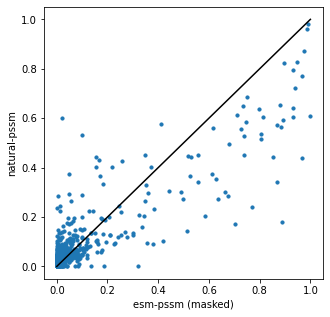

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(softmax(get_masked_logits(seq),-1),
            msa.mean(0)[...,:20],s=10)
plt.xlabel("esm-pssm (masked)")
plt.ylabel("natural-pssm")
plt.plot([0,1],[0,1],color="black")
plt.show()

In [ ]:
# pseudo-likelihood (higher better)
get_masked_logits(seq, get_pll=True)

-57.53443746812438

In [7]:
def get_categorical_jacobian(seq):
  # ∂in/∂out
  x,ln = alphabet.get_batch_converter()([("seq",seq)])[-1],len(seq)
  with torch.no_grad():
    f = lambda x: model(x)["logits"][...,1:(ln+1),4:24].cpu().numpy()
    fx = f(x.to(device))[0]
    x = torch.tile(x,[20,1]).to(device)
    fx_h = np.zeros((ln,20,ln,20))
    for n in range(ln): # for each position
      x_h = torch.clone(x)
      x_h[:,n+1] = torch.arange(4,24) # mutate to all 20 aa
      fx_h[n] = f(x_h)
    return fx-fx_h

In [ ]:
# jacobian of the model
jac = get_categorical_jacobian(seq)
# center & symmetrize
for i in range(4): jac -= jac.mean(i,keepdims=True)
jac = (jac + jac.transpose(2,3,0,1))/2

In [ ]:
# inverse_covariance of natural msa
tmp = inv_cov_jax(msa)
L = len(seq)
ic = tmp["ic"].reshape(L,21,L,21)[:,:20,:,:20]

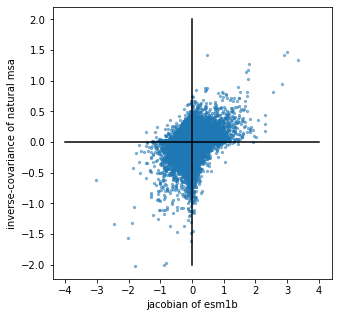

In [ ]:
idx = np.triu_indices(L,1)
plt.figure(figsize=(5,5))
plt.scatter(jac[idx[0],:,idx[1],:],
            ic[idx[0],:,idx[1],:],s=5,alpha=0.5)
plt.xlabel("jacobian of esm1b")
plt.ylabel("inverse-covariance of natural msa")
plt.plot([0,0],[-2,2],color="black")
plt.plot([-4,4],[0,0],color="black")

extract contacts

In [ ]:
plt.figure(figsize=(10,5))
#plt.subplot(1,2,1); plt.title("inv_cov(msa)"); plt.imshow(tmp["apc"])
plt.subplot(1,2,2); plt.title("jac(esm2(msa[0]))"); plt.imshow(get_contacts(jac))
plt.show()

In [ ]:
i = 9
j = 12

# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1);
# plt.title("inv_cov(msa)");
# plt.imshow(ic[i,:,j,:],vmin=-1.5,vmax=1.5,cmap="bwr_r")
# plt.xticks(range(20),esm_alphabet[:20])
# plt.yticks(range(20),esm_alphabet[:20])

plt.subplot(1,2,2);
plt.title("jac(esm1b(msa[0]))");
plt.imshow(jac[i,:,j,:],vmin=-3,vmax=3,cmap="bwr_r")
plt.xticks(range(20),esm_alphabet[:20])
plt.yticks(range(20),esm_alphabet[:20])
plt.show()